<a href="https://colab.research.google.com/github/sumanapalle065/LC25000-Hybrid-Architecture-using-DL/blob/main/mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# !unzip "/content/drive/MyDrive/LC25000.zip"

In [3]:

import cv2
import numpy as np
import os
import glob #for searching based on filename patterns which is generally used to get file paths
import matplotlib.pyplot as matplotlib
import random
import tqdm

from PIL import Image, ImageEnhance

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, InceptionV3, EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score, recall_score, f1_score

import seaborn as sns

from sklearn.metrics import precision_recall_curve, confusion_matrix, average_precision_score

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from keras.models import load_model
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [4]:
#load lung_colon_image_dataset
lung_colon_image_dataset=glob.glob("/content/lung_colon_image_set/*/*/*")
lung_colon_image_dataset

['/content/lung_colon_image_set/lung_image_sets/lung_n/lungn4677.jpeg',
 '/content/lung_colon_image_set/lung_image_sets/lung_n/lungn2805.jpeg',
 '/content/lung_colon_image_set/lung_image_sets/lung_n/lungn1816.jpeg',
 '/content/lung_colon_image_set/lung_image_sets/lung_n/lungn2885.jpeg',
 '/content/lung_colon_image_set/lung_image_sets/lung_n/lungn225.jpeg',
 '/content/lung_colon_image_set/lung_image_sets/lung_n/lungn4574.jpeg',
 '/content/lung_colon_image_set/lung_image_sets/lung_n/lungn2362.jpeg',
 '/content/lung_colon_image_set/lung_image_sets/lung_n/lungn2028.jpeg',
 '/content/lung_colon_image_set/lung_image_sets/lung_n/lungn54.jpeg',
 '/content/lung_colon_image_set/lung_image_sets/lung_n/lungn2832.jpeg',
 '/content/lung_colon_image_set/lung_image_sets/lung_n/lungn2897.jpeg',
 '/content/lung_colon_image_set/lung_image_sets/lung_n/lungn2347.jpeg',
 '/content/lung_colon_image_set/lung_image_sets/lung_n/lungn2426.jpeg',
 '/content/lung_colon_image_set/lung_image_sets/lung_n/lungn1428.jp

In [5]:
len(lung_colon_image_dataset)

25000

In [6]:
from tqdm import tqdm
# Initialize an empty list 'processed_images' to store the processed image data
processed_images = []
# Initialize an empty list 'labels' to hold the corresponding labels of the images
labels = []
# Define a class dictionary called 'label_map' that maps specific class names
label_map = {
    "lung_aca": 0,
    "colon_n": 1,
    "lung_n": 2,
    "lung_scc": 3,
    "colon_aca": 4,
}
# Iterate over the list of path to each image  with a progress bar
for img_path in tqdm(lung_colon_image_dataset):
  # Reading the image from the current path using imread function of OpenCV
    img = cv2.imread(img_path)
    # If the image has failed to load properly, in other words it is None, skip the iteration and move to the next image
    if img is None:
      # Resize image to 148x148 pixels to standardize the size of input
        continue
    img = cv2.resize(img, (148, 148))
 # To blur the resized image by applying  kernel to remove noise in the image and blur.
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

# Convert the blurry image to LAB color space-for better illumination handling
    lab = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2LAB)
    # Split the LAB image into channels L, A and B
    l, a, b = cv2.split(lab)
    # Create a CLAHE object with some clip limit, tile grid size
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Applying CLAHE on the L channel (luminance) for contrast enhancement
    cl = clahe.apply(l)
    # Merging enhanced CLAHE L channel with original A and B channels
    lab_clahe = cv2.merge((cl, a, b))
    # Convert the LAB image back to BGR color space after CLAHE application
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    # Convert CLAHE-enhanced image to grayscale for thresholding and contour detection
    gray = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
    # Use OpenCV's Otsu's thresholding to the grayscale image to get a black and white image with inverted colors
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find contours of the object on the thresholded image using OpenCV's findContours function to detect boundaries and outlines
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Create a mask of zeros filled with black for overlay onto the contours
    mask = np.zeros_like(img)
    # Detect contours in mask, draw them on it with green color, thickness of 2
    cv2.drawContours(mask, contours, -1, (0, 255, 0), 2)
    # Apply mask to the original image using bitwise AND to segment region of interest
    segmented_image = cv2.bitwise_and(img, mask)
    # Convert image from BGR to RGB for appropriate visualisation
    segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)
 # Normalize the segmented image by converting its pixel values to float32 and scaling them to the range
    normalized_img = segmented_image_rgb.astype(np.float32) / 255.0
    # Append normalized image to 'processed_images
    processed_images.append(normalized_img)
    # Extract the class name from the parent directory of the image path that will be assumed as a label
    label = img_path.split(os.path.sep)[-2]
    # Check whether the extracted label is in 'label_map' dictionary or not
    if label in label_map:
      # If label is in 'label_map', append the numeric label corresponding to that one to the 'labels' list
        labels.append(label_map[label])

100%|██████████| 25000/25000 [02:04<00:00, 201.55it/s]


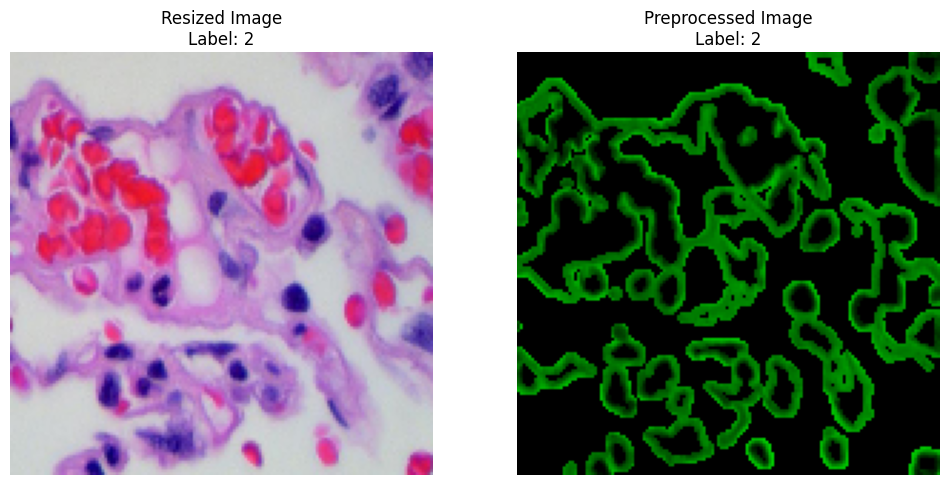

In [7]:
import random
import matplotlib.pyplot as plt

# Select a random image index from the processed images
random_index = random.randint(0, len(processed_images) - 1)

# Get the corresponding original image and its preprocessed version
random_image_path = lung_colon_image_dataset[random_index]  # Get the path of the random image
original_image = cv2.imread(random_image_path)  # Read the original image

# Resize the original image (simulating the same resize step as in preprocessing)
resized_image = cv2.resize(original_image, (148, 148))

# Get the preprocessed (segmented) image and its label
preprocessed_image = processed_images[random_index]
label = labels[random_index]

# Plot the original resized image and preprocessed image side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the resized image on the first subplot
axes[0].imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for visualization
axes[0].set_title(f"Resized Image\nLabel: {label}")
axes[0].axis('off')  # Hide axes for the resized image

# Display the preprocessed image (segmented image) on the second subplot
axes[1].imshow(preprocessed_image)
axes[1].set_title(f"Preprocessed Image\nLabel: {label}")
axes[1].axis('off')  # Hide axes for the preprocessed image

# Show the images
plt.show()


In [8]:
# The list of processed images should be converted into a form that is easily used and manipulated within deep learning models by using a NumPy array.
processed_images_array = np.array(processed_images)
# Convert the list of labels into a NumPy array to match the processed images for model training
labels_array = np.array(labels)
# Print the shape of the 'processed_images_array' to make sure it consists of the correct number of dimensions for all the processed images, that is, the count of images, height, width, and channel
print("Shape of processed_images_array:", processed_images_array.shape)
# Print the shape of 'labels_array' to find out how many labels
print("Shape of labels_array:", labels_array.shape)


Shape of processed_images_array: (25000, 148, 148, 3)
Shape of labels_array: (25000,)


In [9]:
# Splitting the dataset into training and testing sets using sklearn's train_test_split function
X_train, X_test, y_train, y_test = train_test_split(
    # By setting the size of test to 20 percent of the data, you would then train on 80 percent and test on 20 percent.
    processed_images_array, labels_array, test_size=0.2, random_state=100
    # Set random state for reproducibility so the split will always be the same
)

In [10]:
#Print the shape of the training data (X_train) to confirm the dimensions, which include the number of samples and image dimensions
print("X_train shape:", X_train.shape)
#End This prints out shape of testing data X_test, verifying dimensions. It includes number of samples and size of images.
print("X_test shape:", X_test.shape)
# Print the shape of the training labels (y_train) for confirmation of the number of labels in the training dataset
print("y_train shape:", y_train.shape)
# Print the shape of the testing labels (y_test) to check how many labels there are in the testing set
print("y_test shape:", y_test.shape)

X_train shape: (20000, 148, 148, 3)
X_test shape: (5000, 148, 148, 3)
y_train shape: (20000,)
y_test shape: (5000,)


In [11]:
# Convert y_train to one-hot vector in Keras using to categorical
y_train = to_categorical(y_train, num_classes=5)
#Setting num_classes to 5 because we have 5 classes in the dataset. As defined in label_map
y_test = to_categorical(y_test, num_classes=5)
# Transform the testing labels into one-hot encoded format similar to the training labels

In [12]:
#Print the shape of one-hot encoded training labels, y_train to see how many samples and what are the dimensions of a one-hot encoded label
print("y_train_categorical shape:", y_train.shape)
# Print shape of the one-hot encoded testing labels (y_test) to confirm the number of samples and the dimensionality of the one-hot encoded label
print("y_test_categorical shape:", y_test.shape)

y_train_categorical shape: (20000, 5)
y_test_categorical shape: (5000, 5)
